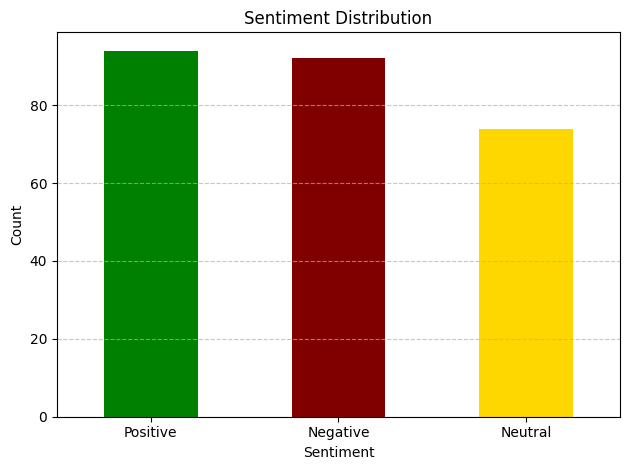

Accuracy: 88.46%

Detailed Report:
              precision    recall  f1-score   support

    Negative       0.84      0.93      0.88        28
     Neutral       0.95      0.86      0.90        22
    Positive       0.89      0.86      0.87        28

    accuracy                           0.88        78
   macro avg       0.89      0.88      0.89        78
weighted avg       0.89      0.88      0.88        78



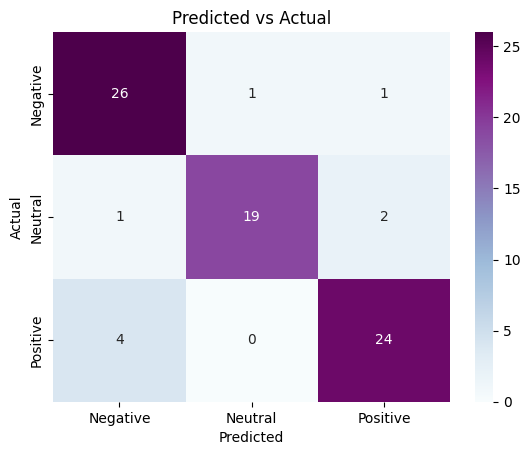


Representative terms for 'Negative': proper, lack, collaborative, environment, technical, process, onboarding

Representative terms for 'Neutral': experience, mention, mixed, slowly, bad, days, productive

Representative terms for 'Positive': team, helpful, learned, exceptional, mentorship, excellent, coordination

Suggested Areas to Improve Intern Satisfaction:
- Proper (mentioned 17 times)
- Lack (mentioned 17 times)
- Tasks (mentioned 16 times)
- Progress (mentioned 16 times)
- Experience (mentioned 14 times)
- Environment (mentioned 10 times)
- Exposure (mentioned 10 times)

Focus on addressing unclear communication, better project direction, and more timely feedback to improve intern experience.

--- Sentiment-Based Feedback Highlights ---

Negative Feedback Analysis:
- Proper (5.59%)
- Lack (5.59%)
- Environment (3.50%)
- Tasks (3.15%)
- Ambiguous (3.15%)

Positive Feedback Analysis:
- Team (5.38%)
- Helpful (5.38%)
- Learned (5.06%)
- Great (2.85%)
- Learning (2.85%)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import warnings
from collections import Counter

warnings.filterwarnings('ignore')

# Extended feedback dataset
positive_fb = [
    "The team was very supportive and I learned a lot.",
    "Great learning opportunity and hands-on experience.",
    "The mentorship was exceptional.",
    "Tasks were well-structured and clear.",
    "Friendly environment and helpful colleagues.",
    "Got good exposure to real projects.",
    "The schedule was flexible and efficient.",
    "Feedback from mentors was helpful and constructive.",
    "Excellent team coordination.",
    "Learned new tools and technologies."
] * 9 + ["Productive internship overall."] * 5

negative_fb = [
    "No proper guidance and lack of communication.",
    "Tasks were ambiguous and poorly explained.",
    "The mentor was unavailable most of the time.",
    "Not enough technical exposure.",
    "I faced delays due to unclear instructions.",
    "The environment was not very collaborative.",
    "Meetings were unproductive and confusing.",
    "I was given repetitive work.",
    "Lack of feedback made progress difficult.",
    "No proper onboarding process."
] * 9 + ["Disorganized structure."] * 5

neutral_fb = [
    "Experience was average with ups and downs.",
    "Learned some new skills but expected more.",
    "It was a decent learning phase.",
    "Not bad, not great either.",
    "Some days were productive, others not.",
    "I made progress, though slowly.",
    "The tasks were okay but lacked innovation.",
    "Mixed experience throughout.",
    "Felt somewhat included.",
    "Nothing much to mention."
] * 7

feedback_data = [(text, "Positive") for text in positive_fb] + \
                [(text, "Negative") for text in negative_fb] + \
                [(text, "Neutral") for text in neutral_fb]

# Add label noise
np.random.seed(42)
noisy_feedback = []
for text, label in feedback_data:
    if np.random.rand() < 0.1:
        new_label = np.random.choice(["Positive", "Negative", "Neutral"])
        noisy_feedback.append((text, new_label))
    else:
        noisy_feedback.append((text, label))

df = pd.DataFrame(noisy_feedback, columns=["feedback", "sentiment"])

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['clean_text'] = df['feedback'].apply(preprocess)

# TF-IDF feature extraction
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Label encoding
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

# Sentiment distribution plot
sentiment_counts = df['sentiment'].value_counts()
colors = {'Positive': 'green', 'Negative': 'maroon', 'Neutral': 'gold'}
sentiment_counts.plot(kind='bar', color=[colors[label] for label in sentiment_counts.index])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, stratify=y, random_state=42)

# Logistic regression model training
lr_model = LogisticRegression(max_iter=300, solver='saga')
lr_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = lr_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", f"{acc:.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Predicted vs Actual")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Extract top words by sentiment group
feature_names = tfidf.get_feature_names_out()
for label_index, label in enumerate(le.classes_):
    idxs = np.where(y == label_index)[0]
    mean_tfidf = X_tfidf[idxs].mean(axis=0).A1
    top_words_idx = mean_tfidf.argsort()[-7:][::-1]
    keywords = [feature_names[i] for i in top_words_idx]
    print(f"\nRepresentative terms for '{label}': {', '.join(keywords)}")

# Identify areas where intern satisfaction can be improved
negative_idxs = df[df['sentiment'] == 'Negative'].index
neutral_idxs = df[df['sentiment'] == 'Neutral'].index

negative_texts = df.loc[negative_idxs, 'clean_text'].tolist()
neutral_texts = df.loc[neutral_idxs, 'clean_text'].tolist()

combined_text = " ".join(negative_texts + neutral_texts)
combined_words = re.findall(r'\b\w+\b', combined_text)
filtered_words = [word for word in combined_words if word not in tfidf.get_stop_words() and len(word) > 3]

common_words = Counter(filtered_words).most_common(7)

print("\nSuggested Areas to Improve Intern Satisfaction:")
for word, freq in common_words:
    print(f"- {word.capitalize()} (mentioned {freq} times)")

print("\nFocus on addressing unclear communication, better project direction, and more timely feedback to improve intern experience.")

# Additional Analysis by Sentiment Type
print("\n--- Sentiment-Based Feedback Highlights ---")
for sentiment in ['Negative', 'Positive']:
    print(f"\n{sentiment} Feedback Analysis:")
    sentiment_texts = df[df['sentiment'] == sentiment]['clean_text'].tolist()
    sentiment_words = re.findall(r'\b\w+\b', " ".join(sentiment_texts))
    sentiment_filtered = [word for word in sentiment_words if word not in tfidf.get_stop_words() and len(word) > 3]
    sentiment_counts = Counter(sentiment_filtered).most_common(5)
    for word, freq in sentiment_counts:
        percent = (freq / len(sentiment_filtered)) * 100
        print(f"- {word.capitalize()} ({percent:.2f}%)")
